### Initial formulation of the problem (Not in standard LP form)

$$\begin{array}{rll}
 \text{max\{ min} & \{7T+5C, 8T+3C, 6T+7C \}\} \\
 \text{s.t.} & 3T + 4C \le 2400 \\
 & 2T + C \le 1000 \\
  &  C \le 450 \\
   & T  \ge 100 \\
 & \text{non-negativity constraints}\\
\end{array}
$$

### Equivalent formulation, in standard LP format

$$\begin{array}{rll}
 \text{max} & Y \\
 \text{s.t.} & 3T + 4C \le 2400 \\
 & 2T + C \le 1000 \\
  &  C \le 450 \\
   & T  \ge 100 \\
   & Y - 7T - 5C \le 0 & (Y \le 7T + 5C)\\
   & Y - 8T - 3C \le 0 & (Y \le 8T + 3C)\\
   & Y - 6T - 7C \le 0 & (Y \le 6T + 7C)\\
 & \text{non-negativity constraints}\\
\end{array}
$$

### Set up Gurobi environment

In [1]:
from gurobipy import *
m = Model()

### Set up variable and constraint Python lists

In [2]:
variables = ["tables", "chairs", "min_profit"]

leq_constraints = ["carpentry_work", "painting", "chairs_upperbound"]
profits_constraints = ["profit1", "profit2", "profit3"]
geq_constraints = ["tables_lowerbound"]

### Set objective coefficients using Python dictionary

In [3]:
profit_contribution = {"tables": 0, "chairs": 0, "min_profit": 1}

### Set the matrix of left-hand-side constraint coefficients (Python dictionary)

In [4]:
# less or equal constraints
lhs_constr_matrix_leq = {
    "carpentry_work": {"tables": 3, "chairs": 4, "min_profit": 0},
    "painting":{"tables": 2, "chairs": 1, "min_profit": 0},
    "chairs_upperbound":{"tables": 0, "chairs": 1, "min_profit": 0}
}

# minimum profit
lhs_constr_matrix_profits = {
    "profit1":{"tables": -7, "chairs": -5, "min_profit": 1},
    "profit2":{"tables": -8, "chairs": -3, "min_profit": 1},
    "profit3":{"tables": -6, "chairs": -7, "min_profit": 1}
}

# greater or equal constraints
lhs_constr_matrix_geq = {
    "tables_lowerbound":{"tables": 1, "chairs": 0, "min_profit": 0}
}


### Load variables into the Gurobi model

In [5]:
variable_levels = m.addVars(variables, name="variable_levels")

### Set the right-hand-side constraint vector (Python dictionary)

In [6]:
rhs_constr_vector = {
    "carpentry_work": 2400,
    "painting": 1000,
    "chairs_upperbound": 450,
    "tables_lowerbound": 100,
    "profit1": 0,
    "profit2": 0,
    "profit3": 0
}

### Load the constraints into Gurobi. The use of quicksum and the for loops is convenient when there are many constraints.

In [7]:
leq_constraints_set = m.addConstrs((quicksum(lhs_constr_matrix_leq[constr][variable]*variable_levels[variable] 
                      for variable in variables) <= rhs_constr_vector[constr]  # use sumproduct to generate one constraint
                      for constr in leq_constraints), name="leq_constraints");           # use for loop to generate all the constraints

profits_constraints_set = m.addConstrs((quicksum(lhs_constr_matrix_profits[constr][variable]*variable_levels[variable] 
                      for variable in variables) <= rhs_constr_vector[constr]
                      for constr in profits_constraints), name="profits_constraints");  

geq_constraints_set = m.addConstrs((quicksum(lhs_constr_matrix_geq[constr][variable]*variable_levels[variable] 
                      for variable in variables) >= rhs_constr_vector[constr]
                      for constr in geq_constraints), name="geq_constraints");  

### Set up the objective function

In [8]:
obj = quicksum(
    profit_contribution[variable] * variable_levels[variable] for variable in variables
)

### Tell Gurobi we want to maximize this objective function

In [9]:
m.setObjective(obj, GRB.MAXIMIZE)

### Tell Gurobi to solve the LP, and look for the optimal objective function value on the last line

In [10]:
m.optimize()

Optimize a model with 7 rows, 3 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+03]
Presolve removed 2 rows and 0 columns
Presolve time: 0.03s
Presolved: 5 rows, 3 columns, 13 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3553510e+03   8.728783e+02   0.000000e+00      0s
       5    3.8000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.05 seconds
Optimal objective  3.800000000e+03


### Ask Gurobi for the optimal decisions

In [11]:
m.printAttr('X')


    Variable            X 
-------------------------
variable_levels[tables]          400 
variable_levels[chairs]          200 
variable_levels[min_profit]         3800 


### Plot

In [12]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import random

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.mlab import griddata
import sys, re, math

<IPython.core.display.Javascript object>


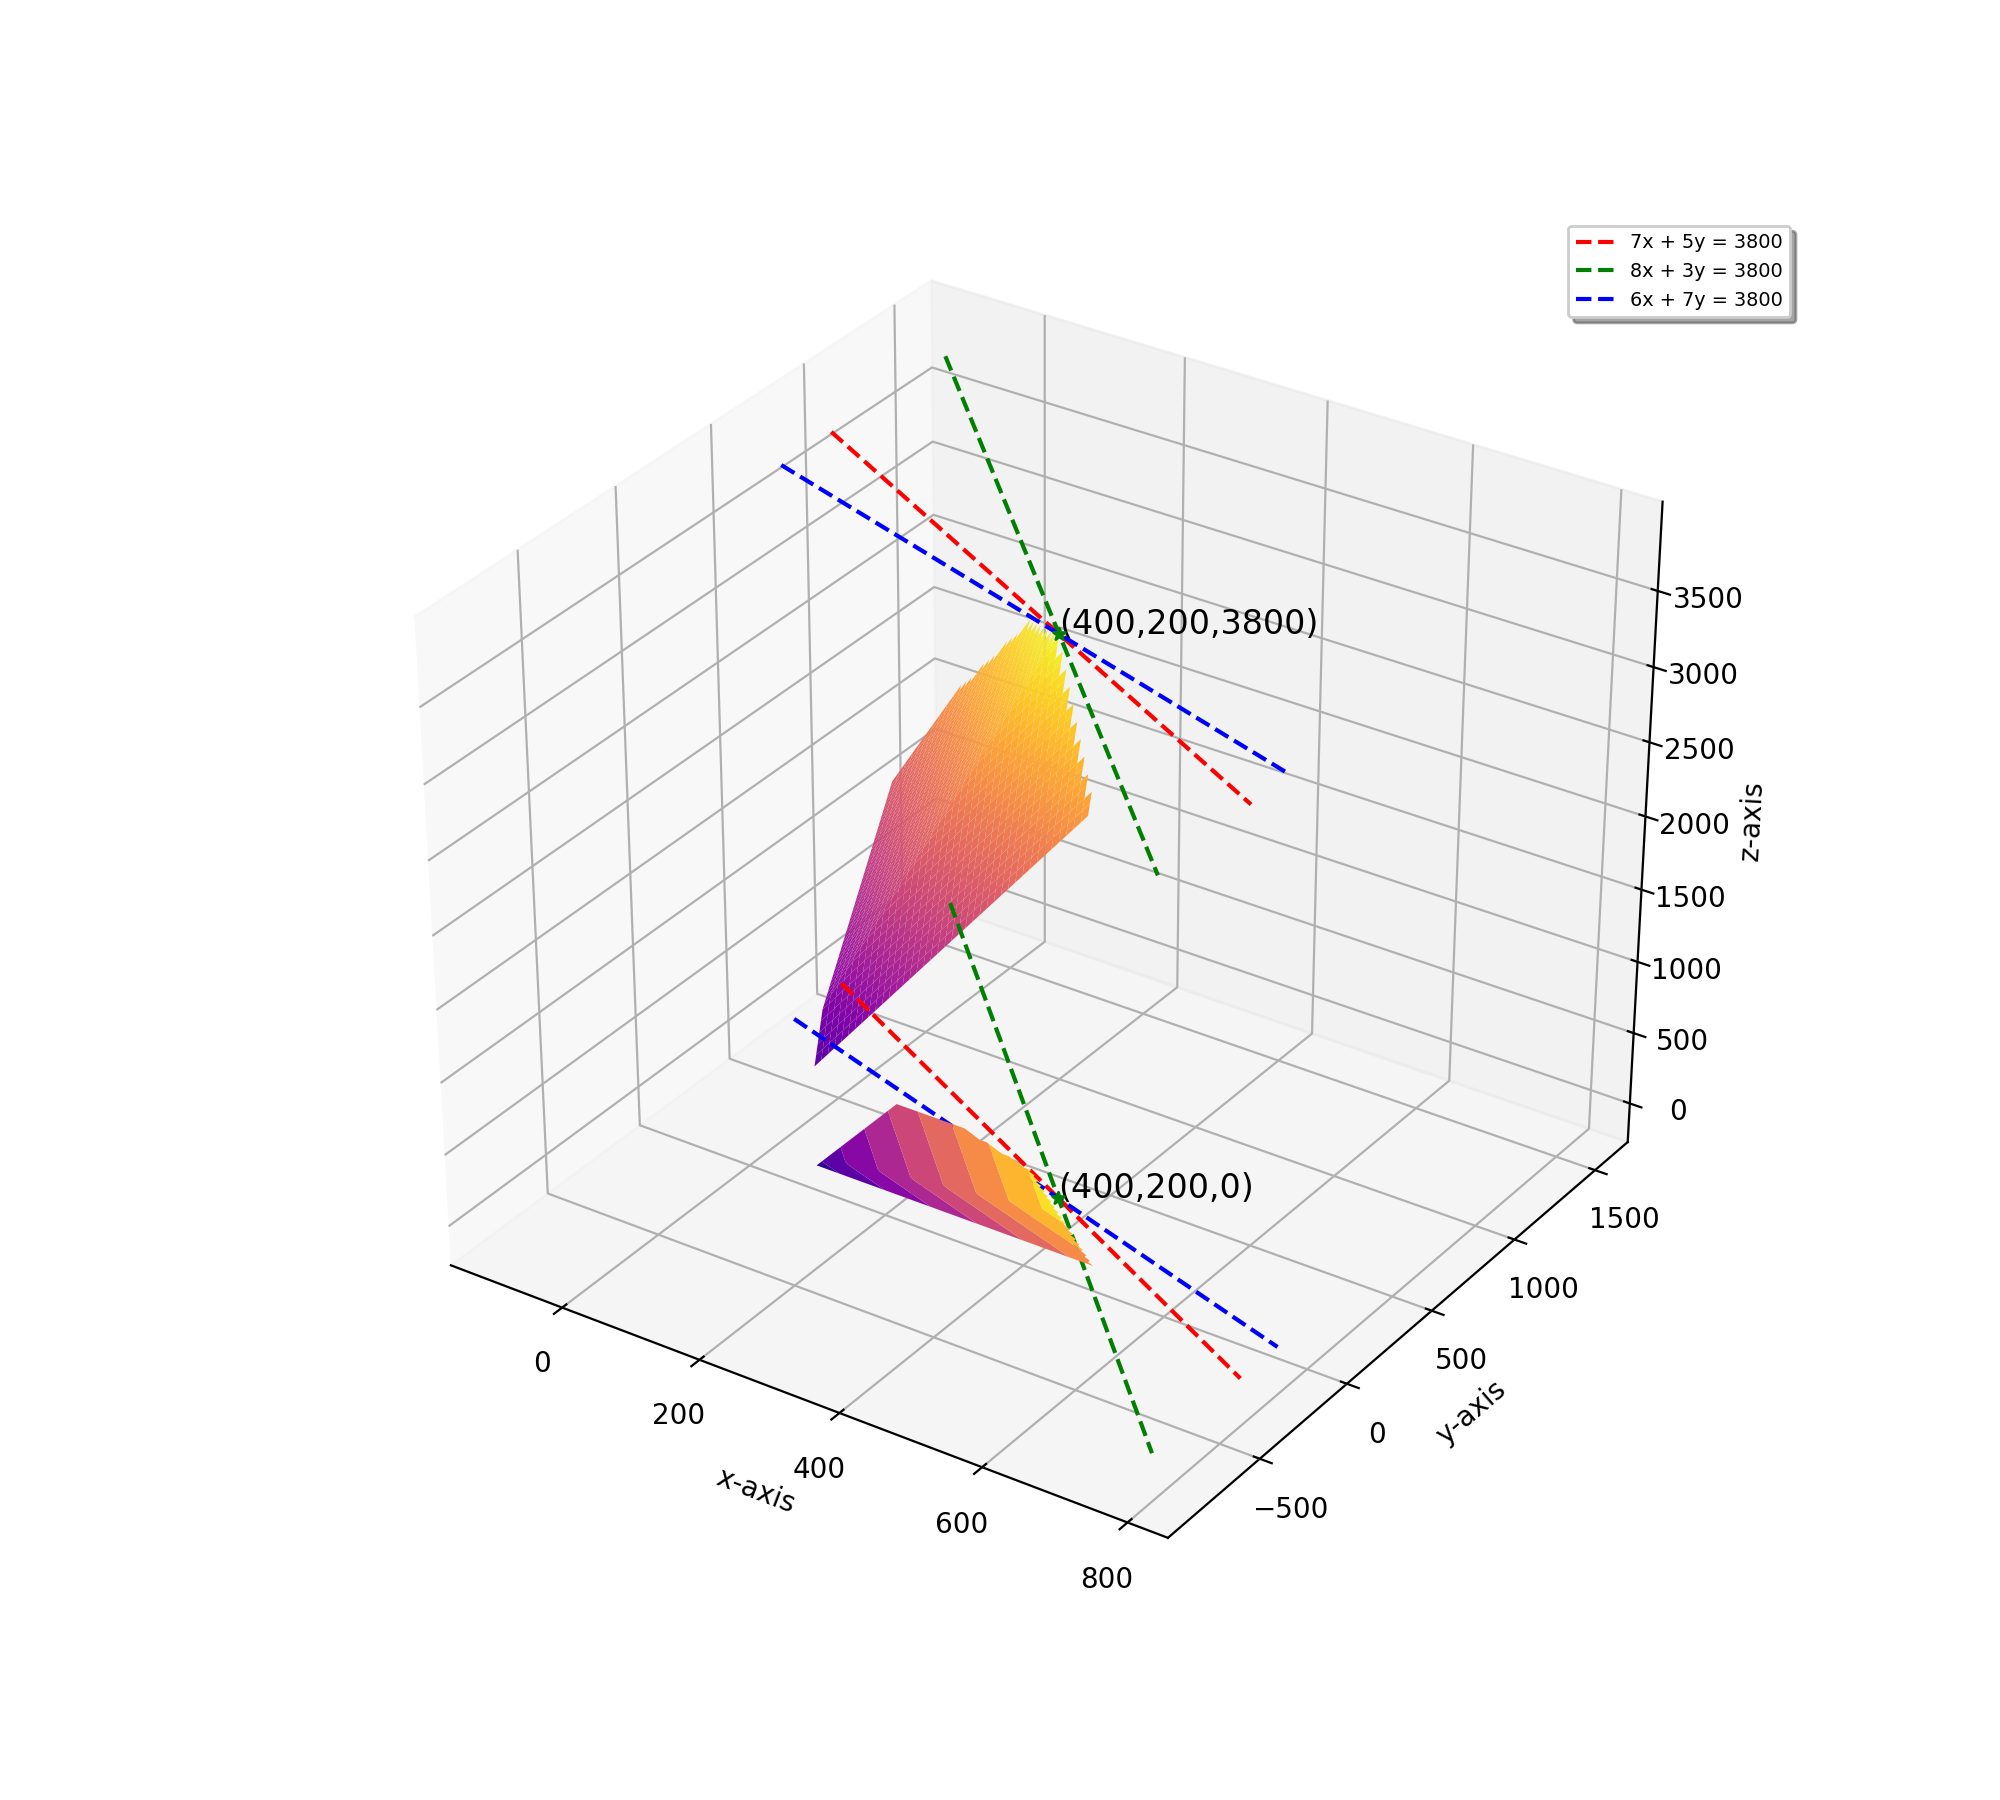

In [18]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(-100.0, 800.0, 10.0)
y = np.arange(-100.0, 800.0, 10.0)
X, Y = np.meshgrid(x, y)


Z = np.ndarray(shape=(len(x),len(y)), dtype=float, order='F')

def func(X, Y):
    for i in range(len(x)):
        for j in range(len(y)):
            a = X[i, j]
            b = Y[i, j]            
            Z[i, j] = min(7*a + 5*b, 8*a + 3*b, 6*a + 7*b)
    return Z

Z = func(X, Y)

# set constraints on domain
Z[3*X + 4*Y > 2400] = np.nan
Z[2*X + Y > 1000] = np.nan
Z[X < 100] = np.nan
Z[Y > 450] = np.nan
Z[Y < 0] = np.nan


# plot surface 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,vmin =0, vmax=np.nanmax(Z), cmap='plasma',
                       linewidth=0, antialiased=True)

# plot projection
ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap='plasma', antialiased=True)


# plot lines
# max = 3800
y1 = (np.nanmax(Z)/5) - (7/5)*x
y2 = (np.nanmax(Z)/3) - (8/3)*x
y3 = (np.nanmax(Z)/7) - (6/7)*x

ax.plot(x,y1,0,'r',linestyle = 'dashed')
ax.plot(x,y2,0,'g',linestyle = 'dashed')
ax.plot(x,y3,0,'b',linestyle = 'dashed')

ax.plot(x,y1,3800,'r',linestyle = 'dashed', label = '7x + 5y = 3800')
ax.plot(x,y2,3800,'g',linestyle = 'dashed', label = '8x + 3y = 3800')
ax.plot(x,y3,3800,'b',linestyle = 'dashed', label = '6x + 7y = 3800')


# max point
ax.scatter(400, 200, 3800, color= 'g',  marker = '*')
ax.text(400, 200, 3800, '(400,200,3800)', size=12, zorder=1, color='k') 

ax.scatter(400, 200, 0, color= 'g',  marker = '*')
ax.text(400, 200, 0, '(400,200,0)', size=12, zorder=1, color='k') 

# set legend
ax.legend(shadow = True, fontsize='x-small')

# set axis
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

plt.rcParams["figure.figsize"] = [10, 9]

plt.show()